In [1]:
%pylab inline

rcParams['font.family'] = 'Arial'
from ipywidgets import interact, interactive
from scipy.optimize import curve_fit
from scipy.optimize import root
import scipy.constants as ct
import ipywidgets
import pandas as pd

from IPython.display import display

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


r1, t1, r2, t2 - отражения и пропускания входного (1) и выходного (2) по амплитуде. R = r^2, T=t^2, R+T+A=1, здесь А - потери по интенсивности на зеркале. q = r1*r2
\begin{equation}
\label{eq1}
E_r = r_1 - t_1^2 r_2/(1-q) \\
E_{in} = t_1 (1 + r_2) / (1-q) \\
E_t = t_1 t_2 / (1-q)
\end{equation} 
Введя, что 
$$
r = \sqrt{1 - T- A}
$$

Для зеркал с малыми потерями для мощности в уравнениее \ref{eq1}.2 можно положить r2=1, тогда коэффициент усиления будет равен
\begin{equation}
\label{eq2}
\eta = (E_{in}/2)^2 = \frac{T_1}{(1-\sqrt{(1 - T_1- A_1)(1 - T_2- A_2)})^2}
\end{equation} 

## Functions

In [3]:
def p_reflected(T1,A1,T2,A2):
    r1 = sqrt(1-T1-A1)
    r2 = sqrt(1-T2-A2)
    return (r1 - T1*r2/(1-r1*r2))**2
def p_transmitted(T1,A1,T2,A2):
    r1 = sqrt(1-T1-A1)
    r2 = sqrt(1-T2-A2)
    return T1*T2/(1-r1*r2)**2
def p_inside(T1,A1,T2,A2):
    r1 = sqrt(1-T1-A1)
    r2 = sqrt(1-T2-A2)
    return T1*(1+r2)**2/(1-r1*r2)**2/4

def m_l(l):
    """Free space matrix, l - optical path [meters] = d*n, n-reflactive index, d-real distance"""
    return array([[1,l],
                  [0,1]])

def m_f(f):
    """Thin lens matrix, f - rear focal distance [meters]"""
    return array([[1,0],
                  [-1/f,1]])

def z_r(w0,lda):
    """Calculates rayleigh range [m], w0 - waist [m], lda - wavelength [m]"""
    return (pi*w0**2/lda)

def q(z,zr=None,w0=None,z0=0):
    """calculates q-parameter,z - coordinate [m] (distance to the waist position if z0=0), z_r - rayleigh range [m]
    or waist radios w0 [m], z0 - distance to the waist"""
    if zr == None:
        zr = z_r(w0,lda)
    return (z-z0)+1j*zr

def w_z(z,lda,zr=None,w0=None,z0=0):
    """calculates beam radius [m] based on z_r - rayleigh range [m] or waist radius w0 [m],lda - wavelength [m]"""
    if zr == None:
        zr = z_r(w0,lda)
    return sqrt(lda / pi * zr)*sqrt(1 + (z-z0)**2/zr**2)


def get_w(q,lda):
    """Returns beam radius w [m] based on q-parameter"""
    return sqrt(lda / (pi * imag(-1/q)))

def get_w0(q,lda):
    """Returns beam waist radius w [m] based on q-parameter"""
    return sqrt(lda / pi * imag(q))

def waist_and_pos(z,z0,w0):
    return waist(z-z0,w0)

def finesse (R,A):
    """R - input mirror reflectivity, A - losses in the cavity"""
    return pi/(1 - sqrt(R*(1-A)))

def apply_m_to_q(m,q):
    """Apply matrix m to q-parameter"""
    return (m[0,0]*q + m[0,1]) / (m[1,0]*q + m[1,1])

def matrix_mult(*mts):
    """Multiplies matrixes mts: m1*m2...*mN"""
    if len(mts) > 1:
        res = mts[0]
        for m in mts[1:]:
            res = dot(m,res)
        return res
    
    


In [4]:
class BeamTrace:
    def __init__(self,matrexes,q_in,z0=0,n_points=10):
        self.n_points = n_points
        self.z0 = z0 #distance from q_in point to 0, needed only for convinience
        self.matrexes = matrexes # array of matrixes or labels - strings (names) at wich to calculate q-parameter
        self.xs = [] # x coordinates
        self.ws = [] # beam waists vs. xs
        self.qz_to_print = [] # future array of (label,q) for labels in matrexes
        self.q_in = q_in # initial q-parameter of the beam
        
    def constructRey(self):
        """Function that construct waists vs x posision"""
        self.xs = []
        self.ws = []
        self.qs_to_print = []
        q_in = self.q_in
        direction = 1 # direction of the beam (if mirror comes it changes the direction)
        for M in self.matrexes:
            
            if type(M) == str: # it is a label to save current beam parameter
                    self.qs_to_print.append((M,get_w(q_in,lda),q_in))
                    print(self.qs_to_print[-1])
                    continue
                    
            if M[0][1] != 0: # it is free space matrix 
                xs = linspace(0,M[0][1],self.n_points)
                ws = w_z(xs+real(q_in),lda=lda,zr=imag(q_in)) # calculates waists
                #print(ws)
                
                if self.xs != []: # point where if stoped in previous matrix
                    extr = self.xs[-1]
                else :
                    extr = self.z0
                    
                self.xs.extend(direction*xs+extr)
                self.ws.extend(ws)
                
            elif M[0][1] == 0 and M[1][0] == 0: # ones matrix means a mirror - change of the direction
                direction *= -1
                continue
            q_in = apply_m_to_q(M,q_in) #calculate new q-parameter for the next matrix
        

## Beam

In [5]:
lda=780e-9
arr = array([
    (1, 450, 1350),
#    (232, 4340, 2486),
#    (261, 4159, 2288),
    (150, 2280, 52),
#    (320, 4640, 2260),
    (300, 2450, 55),
    (600, 3260, 60),
])#(L[mm], Dx[mkm], Dy[mkm])
L = arr[:,0]*1e-3
Rx = arr[:,1]*1e-6
Ry = arr[:,2]*1e-6
print(L,Rx,Ry)
def wz(z,w0,z0):
    return w0*sqrt(1+((z-z0)/z_r(w0,lda))**2)

[0.001 0.15  0.3   0.6  ] [0.00045 0.00228 0.00245 0.00326] [1.35e-03 5.20e-05 5.50e-05 6.00e-05]


In [6]:
#plt.plot(L*1000, Rx*1e6, '.')
popt, pcov = curve_fit(wz, L, Rx, p0 = (2e-3, -2))
R0x = popt[0] #[mkm]
Z0x = popt[1] #[mm]
l = np.linspace(-2, 2, 1000)
#plt.plot(l*1e3, wz(l, *popt)*1e6, 'r')
print(R0x,Z0x)
q_0=-1j*2*np.pi*(R0x**2)/780e-9
print(q_0)

5.97314101163461e-05 -0.2446554326038484
-0.028740267149822137j


nan


/var/folders/h9/ll8t8frd1r575llt96l1glhm0000gn/T/ipykernel_47517/3789569966.py:39: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(lda / pi * zr)*sqrt(1 + (z-z0)**2/zr**2)


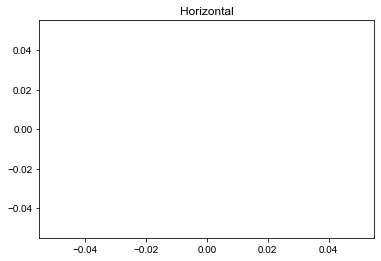

In [7]:
L_1=0.6
L_2=0.5
tisa = BeamTrace([m_l(L_1)],
                     z0=0,
                     q_in=q_0,n_points=100)
tisa.constructRey()
plot(tisa.xs,array(tisa.ws)*1e6)
title("Horizontal")
print(min(array(tisa.ws)*1e6))

# Resonator

In [8]:
p_reflected(0.2,0,0.005,0.4)

0.15752192379130373

In [41]:
# L1=0.02
# f1=0.1
# L2=0.15
# f2=0.1
# L3=0.02
# R=0.25

# cavity = matrix_mult(
#                     m_l(L2/2),
#                     m_f(f2),
#                     m_l(L3),
#                     m_l(L3),
#                     m_f(f2),
#                     m_l(L2),
#                     m_f(f1),
#                     m_l(L1),
#                     m_l(L1),
#                     m_f(f1),
#                     m_l(L2/2)
#                     )


R = 25e-2
L = 13e-2

cavity = matrix_mult(m_l(L), m_f(R/2), m_l(L))



res0 = root(lambda x: abs(apply_m_to_q(cavity,1j*x)-1j*x),20e-6)
w0 = w_z(z=0,lda=lda,zr=res0.x[0])
# print(res0)
print(w0*1e3)

0.1760976314223898


Text(0.5, 1.0, 'Horizontal')

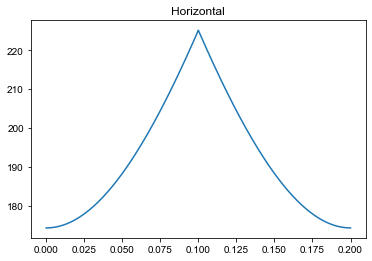

In [31]:
# tisa = BeamTrace([ m_l(L2/2),
#                     m_f(f2),
#                     m_l(L3),
#                     m_l(L3),
#                     m_f(f2),
#                     m_l(L2),
#                     m_f(f1),
#                     m_l(L1),
#                     m_l(L1),
#                     m_f(f1),
#                     m_l(L2/2)],
#                      z0=0,
#                      q_in=1j*abs(res0.x[0]),n_points=100)

tisa = BeamTrace([m_l(L), m_f(R/2), m_l(L)], q_in=1j*abs(res0.x[0]),n_points=100)
tisa.constructRey()
plot(tisa.xs,array(tisa.ws)*1e6)
title("Horizontal")

In [11]:
780e-9/3e-3*0.25

6.500000000000001e-05

## 3 зеркала

In [12]:
L_1=1

R=2

cavity = matrix_mult(m_l(L_1),
                          m_f(R/2),
                          m_l(L_1))

def func(x):
    return [0, abs(apply_m_to_q(cavity,x[0]+1j*x[1])-x[0]-1j*x[1])]
    
res0 = root(func,[1,1e-6])
w0 = w_z(z=0,lda=lda,zr=(abs(res0.x[1])))

print(res0)
print(w0*1e6)
print(res0.x)

    fjac: array([[ 0., -1.],
       [-1.,  0.]])
     fun: array([0., 2.])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 15
     qtf: array([-2.,  0.])
       r: array([0.00011195, 0.        , 0.        ])
  status: 5
 success: False
       x: array([1.e+00, 1.e-06])
0.4982787485166879
[1.e+00 1.e-06]


In [13]:
tisa = BeamTrace([m_l(L_1),
                m_f(R*np.cos(phi)/2),
                m_l(L_1)],
                     z0=0,
                     q_in=1j*abs(res0.x[0]),n_points=100)
tisa.constructRey()
plot(tisa.xs,array(tisa.ws)*1e6)
title("Horizontal")

NameError: name 'phi' is not defined

In [14]:
L_1=0.085
L_2=0.13

R=0.1
phi = 0
cavity = matrix_mult(m_l(L_1),
                          m_f(R*np.cos(phi)/2),
                          m_l(L_1))
res0 = root(lambda x: abs(apply_m_to_q(cavity,1j*x)-1j*x),20e-6)
w0 = w_z(z=0,lda=lda,zr=res0.x[0])
print(w0*1e6)

94.1564143013567


Text(0.5, 1.0, 'Horizontal')

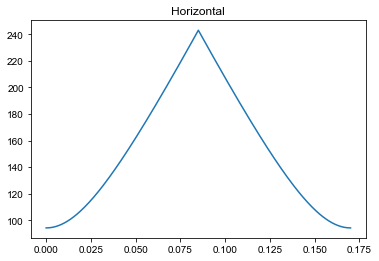

In [15]:
tisa = BeamTrace([m_l(L_1),
                m_f(R*np.cos(phi)/2),
                m_l(L_1)],
                     z0=0,
                     q_in=1j*res0.x[0],n_points=100)
tisa.constructRey()
plot(tisa.xs,array(tisa.ws)*1e6)
title("Horizontal")

In [16]:
tisa = BeamTrace([m_l(L),m_f(R/2), m_l(L)],
                     z0=0,
                     q_in=1j*res0.x[0],n_points=100)
tisa.constructRey()
plot(tisa.xs,array(tisa.ws)*1e6)
title("Horizontal")

/var/folders/h9/ll8t8frd1r575llt96l1glhm0000gn/T/ipykernel_47517/3789569966.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array([[1,l],


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
l_short=47.6e-3#48.2e-3 #49.1
l_long=80.0e-3#68e-3 #76.2
teta = radians(18)
l_diagonal=(l_short+l_long)/(2*cos(teta)) #67.6
print(l_diagonal*1e3)
n_criystal=1.610#6
l_crystal=10e-3
r = 40e-3
lda=820e-9 #972e-9

cavity_hor = matrix_mult(m_l(l_crystal/(2*n_criystal)),
                          m_l((l_short-l_crystal)/2),
                          m_f(r*cos(teta)/2),
                          m_l(l_diagonal+l_long + l_diagonal),
                          m_f(r*cos(teta)/2),
                          m_l((l_short-l_crystal)/2),
                          m_l(l_crystal/(2*n_criystal)))
# print(cavity_hor)
res0 = root(lambda x: abs(apply_m_to_q(cavity_hor,1j*x)-1j*x),20e-6)
w0 = w_z(z=0,lda=lda,zr=res0.x[0])
print(w0*1e6)
cavity_ver = matrix_mult(m_l(l_crystal/(2*n_criystal)),
                          m_l((l_short-l_crystal)/2),
                          m_f(r/(2*cos(teta))),
                          m_l(l_diagonal+l_long + l_diagonal),
                          m_f(r/(2*cos(teta))),
                          m_l((l_short-l_crystal)/2),
                          m_l(l_crystal/(2*n_criystal)))
# print(cavity_ver)
# lda=972e-9
res1 = root(lambda x: abs(apply_m_to_q(cavity_ver,1j*x)-1j*x),20e-6)
w0 = w_z(z=0,lda=lda,zr=res1.x[0])
print(w0*1e6)

In [17]:
tisa = BeamTrace([m_l(l_crystal/(2*n_criystal)),m_l((l_short-l_crystal)/2),m_f(r*cos(teta)/2),
                  m_l(l_diagonal+l_long/2),'center',m_l(l_diagonal+l_long/2),m_f(r*cos(teta)/2),
                  m_l((l_short-l_crystal)/2),m_l(l_crystal/(2*n_criystal))],
                     z0=0,
                     q_in=1j*res0.x[0],n_points=100)
tisa.constructRey()
plot(tisa.xs,array(tisa.ws)*1e6)
title("Horizontal")

NameError: name 'l_crystal' is not defined